# Influencer Loss Example

## The Plan

We are going to walkthrough an example of how to use the influencer loss with a transformer model to assign hits to tracks. See the [CTD2023 Presentation](https://indico.cern.ch/event/1252748/contributions/5520692/attachments/2730952/4747441/Influencer%20Finding%20and%20Fitting%20Public.pdf) for more details.

1. Load a model
2. Inspect an example event
3. Train the model
4. Inspect the results

## Setup

In [71]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import torch
import lightning.pytorch as pl
from lightning.pytorch.loggers import WandbLogger
import numpy as np

import warnings

warnings.filterwarnings("ignore")
sys.path.append("../")
device = "cuda" if torch.cuda.is_available() else "cpu"

from src.models import InfluencerModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load config
with open("test_influencer_config.yaml", "r") as f:
    config = yaml.safe_load(f)
model = InfluencerModel(config)

In [3]:
model.setup(stage="fit")

Setting up the data...


## Data Inspection

In [4]:
trainset = model.trainset
sample = trainset[0]

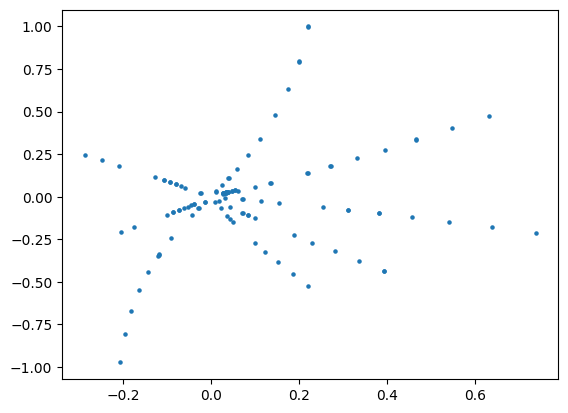

In [9]:
x, y = sample.x.T[:2].numpy()
plt.scatter(x, y, s=5)

## Training

In [ ]:
logger = WandbLogger(
    project="InfluencerNetworkTraining", save_dir=config["artifacts"]
)
trainer = pl.Trainer(
    accelerator="gpu", devices=1, max_epochs=config["max_epochs"], logger=logger, num_sanity_val_steps=0
)
trainer.fit(model)

## Evaluation

In [13]:
# Load a pretrained model
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/artifacts/last-ehfht4r0.ckpt"

model = InfluencerModel.load_from_checkpoint(checkpoint_path).to("cuda")

In [35]:
model.setup(stage="fit")
trainset = model.trainset
sample = trainset[0].to("cuda")

Setting up the data...


In [49]:
# apply model to data
with torch.no_grad():
    model.eval()
    output = model.shared_evaluation(sample, batch_idx=0, val_radius=1.0)

VAL_RADIUS =  1.0
Tracking eff: 1.0, tracking pur: 1.0, tracking dup: 0.5454545454545454, 
 num_valid_matched_particles: 10, num_valid_particles: 10, num_valid_matched_clusters: 22, num_valid_clusters: 22, num_duplicated_clusters: 12


### Plan

1. PCA user and influencer embeddings down to 2d
2. Visualize the embeddings
3. Plot in x-y the influencers and users
4. Eyeball the duplication rate

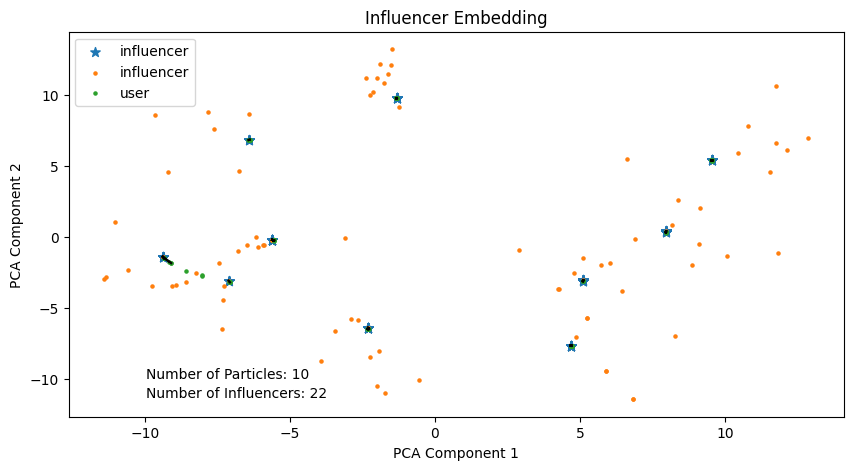

In [81]:
inf_embedding = output["influencer_embed"].cpu().numpy()
user_embedding = output["user_embed"].cpu().numpy()
inf_user_edges = output["user_influencer_edges"].cpu().numpy()

# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
# fit both embeddings
pca.fit(inf_embedding)
pca.fit(user_embedding)

# transform both embeddings
inf_embedding_pca = pca.transform(inf_embedding)
user_embedding_pca = pca.transform(user_embedding)

# plot both embeddings
plt.figure(figsize=(10, 5))

# plot edges
for i in range(inf_user_edges.shape[1]):
    plt.plot([user_embedding_pca[inf_user_edges[0, i], 0], inf_embedding_pca[inf_user_edges[1, i], 0]], 
             [user_embedding_pca[inf_user_edges[0, i], 1], inf_embedding_pca[inf_user_edges[1, i], 1]], 
             'k-', alpha=0.5)

# plot nodes
plt.scatter(inf_embedding_pca[inf_user_edges[1], 0], inf_embedding_pca[inf_user_edges[1], 1], s=50, marker='*', label="influencer")
plt.scatter(inf_embedding_pca[:, 0], inf_embedding_pca[:, 1], s=5, label="influencer")
plt.scatter(user_embedding_pca[:, 0], user_embedding_pca[:, 1], s=5, label="user")

plt.legend()

# Add some stats to the image
plt.title("Influencer Embedding")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
# Add text showing the number of particles, (number of unique entries in sample.pid)
plt.text(0.1, 0.1, f"Number of Particles: {len(sample.pid.unique())}", transform=plt.gca().transAxes);
# Number of influencers (unique stars nodes in plot)
plt.text(0.1, 0.05, f"Number of Influencers: {len(np.unique(inf_user_edges[1]))}", transform=plt.gca().transAxes);

Text(0.1, 0.05, 'Number of Influencers: 22')

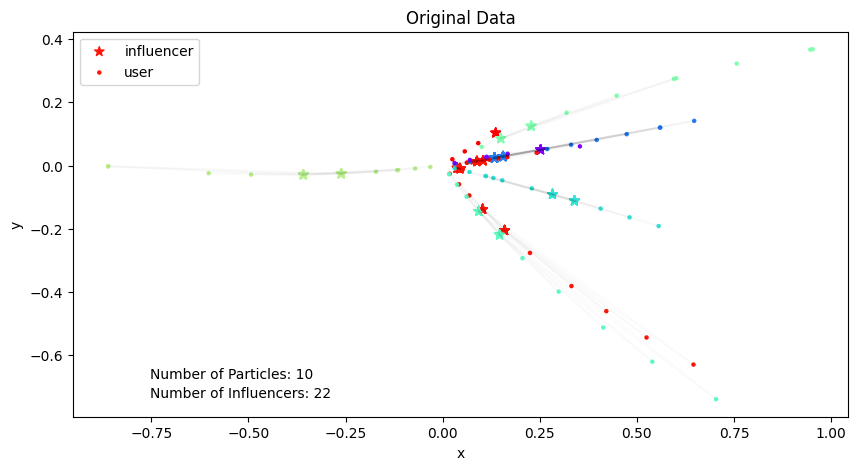

In [80]:
# Get the original x, y coordinates
x, y = sample.x.T[:2].cpu().numpy()
pid = sample.pid.cpu().numpy()  # Get particle IDs

# Create a colormap
cmap = plt.get_cmap('rainbow')
colors = cmap(pid / np.max(pid))  # Normalize pid to [0, 1] for color mapping

# Plot the original data
plt.figure(figsize=(10, 5))

# Plot edges
for i in range(inf_user_edges.shape[1]):
    plt.plot([x[inf_user_edges[0, i]], x[inf_user_edges[1, i]]], 
             [y[inf_user_edges[0, i]], y[inf_user_edges[1, i]]], 
             'k-', alpha=0.01)

# Plot nodes
plt.scatter(x[inf_user_edges[1]], y[inf_user_edges[1]], s=50, marker='*', label="influencer", c=colors[inf_user_edges[1]])  # Use colors for influencers
plt.scatter(x, y, s=5, c=colors, label="user")  # Use colors for users

plt.legend()

# Add some stats to the image
plt.title("Original Data")
plt.xlabel("x")
plt.ylabel("y")
# Add text showing the number of particles, (number of unique entries in sample.pid)
plt.text(0.1, 0.1, f"Number of Particles: {len(sample.pid.unique())}", transform=plt.gca().transAxes);
# Number of influencers (unique stars nodes in plot)
plt.text(0.1, 0.05, f"Number of Influencers: {len(np.unique(inf_user_edges[1]))}", transform=plt.gca().transAxes);